In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline

In [2]:
# Static Variables

INPUT_DATA_PATH = './data/input/'
OUTPUT_DATA_PATH = './data/output/'
FILENAMES = ['2019.xlsx', '2018.xlsx', '2017.xlsx', '2016.xlsx', '2015.xlsx', '2014.xlsx', '2013.xlsx', '2012.xls', '2011.xls', '2010.xls', '2009.xls', '2008.xls', '2007.xls', '2006.xls', '2005.xls', '2004.xls', '2003.xls', '2002.xls', '2001.xls']
OUTPUT_DATASET_FILE = 'output_clean.xlsx'

In [3]:
# Column headers
columns = pd.read_excel(INPUT_DATA_PATH + FILENAMES[0], header=None)
columns = columns.loc[0,:].values.tolist()

# instantiating an empty dataframe
df = pd.DataFrame(columns=columns)

# iterating through our files to load all the training data for different years
for filename in FILENAMES:
    data = pd.read_excel(INPUT_DATA_PATH + filename, index_col=None, header=0)
    df = df.append(data, ignore_index=True)

# loading our dataframe
df

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,CBW,CBL,IWW,IWL,SBW,SBL,B&WW,B&WL,GBW,GBL
0,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Dimitrov G.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Raonic M.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Kecmanovic M.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Millman J.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Uchiyama Y.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51940,69,Sydney,Masters Cup,2001-11-12,Masters Cup,Indoor,Hard,Round Robin,3,Kafelnikov Y.,...,1.53,2.45,1.35,2.5,1.5,2.500,NaN,NaN,1.45,2.45
51941,69,Sydney,Masters Cup,2001-11-12,Masters Cup,Indoor,Hard,Round Robin,3,Kafelnikov Y.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51942,69,Sydney,Masters Cup,2001-11-12,Masters Cup,Indoor,Hard,Semifinals,3,Grosjean S.,...,2.05,1.70,1.80,1.7,2.1,1.667,NaN,NaN,1.95,1.70
51943,69,Sydney,Masters Cup,2001-11-12,Masters Cup,Indoor,Hard,Semifinals,3,Hewitt L.,...,1.45,2.55,1.20,3.3,1.3,3.200,NaN,NaN,1.20,3.80


## Data Pre-processing

In [4]:
def clean_data_1(df):
    '''
    Initial cleaning of our dataframe
    '''
    
    # Removing entries where the match was not completed
    df = df[df['Comment']=='Completed']
    
    # Remove Max and Avg Betting Odds columns
    df.drop(['MaxW', 'MaxL', 'AvgW', 'AvgL'], axis=1, inplace=True)
    
    # Creating a new feature consolidating the betting odds
    winner_odds_idx = list(range(28,df.shape[1],2))
    loser_odds_idx = list(range(29, df.shape[1],2))
    df['W_Avg_Odds'] = df.iloc[:, winner_odds_idx].mean(axis=1, skipna=True)
    df['L_Avg_Odds'] = df.iloc[:, loser_odds_idx].mean(axis=1, skipna=True)
    
    # Datatype conversion, changing inconsistent data values to NaN with errors='coerce'
    date_columns = ['Date']
    numeric_columns = ['WRank', 'LRank', 'WPts', 'LPts', 'W1', 'L1', 'W_Avg_Odds', 'L_Avg_Odds']
    df[date_columns] = df[date_columns].apply(pd.to_datetime, errors='coerce')
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
    
    return df


def restructure_winner_loser(df):
    '''
    Purpose is to rearrange the dataframe, such that the features are not based on winner and loser,
    but structured based on Player and Opponent, where Player is always the person whom is losing the first set
    Output df is therefore with a new feature Has_Won, which indicates whether Player has won against Opponent
    '''
    
    # since our dataset is already structured, such that the winner and loser player is arranged for each event
    # then we need to create a new dataframe, such that the player behind will be relabelled as Player, and the other as 
    # Opponent respectively.  We can then provide labels on 0 or 1 for "has_won" which will be our new feature
    common_cols = ['Date', 'Court', 'Surface', 'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'WPts', 'LPts', 'W1', 'L1', 'W_Avg_Odds', 'L_Avg_Odds']
    winner_matches_df = df[common_cols].copy(deep=True)
    loser_matches_df = df[common_cols].copy(deep=True)

    winner_matches_df['Has_Won'] = 1
    loser_matches_df['Has_Won'] = 0
    
    winner_matches_df.rename(columns={
        'Winner': 'Player',
        'Loser': 'Opponent',
        'WRank': 'PRank',
        'LRank': 'ORank',
        'WPts': 'PPts',
        'LPts': 'OPts',
        'W1': 'P1',
        'L1': 'O1',
        'W_Avg_Odds': 'P_Avg_Odds',
        'L_Avg_Odds': 'O_Avg_Odds'
    }, inplace=True)

    loser_matches_df.rename(columns={
        'Loser': 'Player',
        'Winner': 'Opponent',
        'LRank': 'PRank',
        'WRank': 'ORank',
        'LPts': 'PPts',
        'WPts': 'OPts',
        'L1': 'P1',
        'W1': 'O1',
        'L_Avg_Odds': 'P_Avg_Odds',
        'W_Avg_Odds': 'O_Avg_Odds'
    }, inplace=True)

    # Now that we have the same columns for both winner and loser dataframes, we can now merge it back to training_df
    # except this time, each event is represented twice: first where the player is in col "Player" and then as "Opponent"
    # we will then later extract the rows where the player is behind effectively having a dataset where the player behind
    # is set as Player, with our classifier ("has_won") will then be mixed between 0 or 1, as opposed to our original dataset
    df = winner_matches_df.append(loser_matches_df)
    df['Set1_Diff'] = df['P1'] - df['O1']
    df.drop(['P1', 'O1'], axis=1, inplace=True)

    # We only want the rows where the player is behind. We therefore have restored our dataset back to the original row size
    df = df[df['Set1_Diff']<0]
    
    # Further reduction of features by condensing it
    df['Rank_Diff'] = df['PRank'] - df['ORank']
    df.drop(['PRank', 'ORank'], axis=1, inplace=True)
    
    df['Pts_Diff'] = df['PPts'] - df['OPts']
    df.drop(['PPts', 'OPts'], axis=1, inplace=True)

    # Sort the dataframe by date ASC
    df.sort_values(by=['Date', 'Round', 'Player'], inplace=True)

    # Reset the index
    df.reset_index(inplace=True, drop=True)
    
    return df


def create_momentum_feature(df):
    '''
    Creates the additional feature for Momentum.  This gives an insight to the player's recent form
    and adds an extra dimension for our classification model
    '''
    
    # Creating additional feature to show the momentum of the player coming into the game
    # This will take into account the past 10 matches of the player and opponent before the current row(event)
    df['PMomentum10'] = ''
    df['OMomentum10'] = ''

    for row in range(0,df.shape[0]):
        current_player = df['Player'][row]
        current_opponent = df['Opponent'][row]

        # Gets the last 10 matches of the player
        # Note that you purposely don't want the current match to be included.  This is why we only do slice(row-1),
        # and not slice(row), because we want the previous 10 matches - excluding the current one.
        dataset = df.loc[slice(row-1),:][(df['Player'] == current_player) | (df['Opponent'] == current_player)].tail(10)
        momentum = ((dataset['Player']==current_player).astype(int)*dataset['Has_Won']).sum() + ((dataset['Opponent']==current_player).astype(int)*abs(dataset['Has_Won']-1)).sum()
        df['PMomentum10'][row] = momentum

        dataset = df.loc[slice(row-1),:][(df['Player'] == current_opponent) | (df['Opponent'] == current_opponent)].tail(10)
        momentum = ((dataset['Player']==current_opponent).astype(int)*dataset['Has_Won']).sum() + ((dataset['Opponent']==current_opponent).astype(int)*abs(dataset['Has_Won']-1)).sum()
        df['OMomentum10'][row] = momentum
        
    return df


def clean_data_2(df):
    '''
    Further reduce the number of unnecessary features
    '''
    
    # We now condense the two columns PMomentum10 and OMomentum10 into Momentum10_Diff
    df['Momentum10_Diff'] = df['PMomentum10'] - df['OMomentum10']
    df.drop(['PMomentum10', 'OMomentum10'], axis=1, inplace=True)
    
    df.drop(['Player', 'Opponent'], axis=1, inplace=True)
    
    # Rearrange the columns to make the classifier label the last column for viewing purposes
    df = df[[c for c in df if c not in ['Has_Won']] + ['Has_Won']]

    return df


In [5]:
df = clean_data_1(df)
df = restructure_winner_loser(df)
df = create_momentum_feature(df)
df = clean_data_2(df)

# Verification of the dataset
df.tail(20)

c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,Date,Court,Surface,Round,Best of,P_Avg_Odds,O_Avg_Odds,Set1_Diff,Rank_Diff,Pts_Diff,Momentum10_Diff,Has_Won
49993,2019-11-01,Indoor,Hard,Quarterfinals,3,2.185,1.720,-4.0,-15.0,890.0,-1,0
49994,2019-11-01,Indoor,Hard,Quarterfinals,3,3.615,1.315,-5.0,6.0,-5715.0,-1,0
49995,2019-11-01,Indoor,Hard,Quarterfinals,3,5.790,1.155,-1.0,33.0,-7995.0,-2,0
49996,2019-11-02,Indoor,Hard,Semifinals,3,7.375,1.110,-1.0,26.0,-8068.0,-3,0
49997,2019-11-03,Indoor,Hard,The Final,3,6.155,1.140,-3.0,27.0,-8085.0,-1,0
49998,2019-11-10,Indoor,Hard,Round Robin,3,7.030,1.115,-4.0,6.0,-6275.0,-5,0
49999,2019-11-10,Indoor,Hard,Round Robin,3,1.305,3.720,-2.0,-2.0,1165.0,4,0
50000,2019-11-11,Indoor,Hard,Round Robin,3,1.410,3.070,-1.0,-2.0,1705.0,0,0
50001,2019-11-11,Indoor,Hard,Round Robin,3,1.405,3.095,-4.0,-6.0,6640.0,0,0
50002,2019-11-12,Indoor,Hard,Round Robin,3,5.420,1.165,-1.0,5.0,-3520.0,-4,0


In [6]:
# Exporting our dataset, so we can quickly re-import without having to re-run all the data pre-processing steps
df.to_excel(OUTPUT_DATA_PATH + OUTPUT_DATASET_FILE, index=False)

## Data Analysis and Visualisation

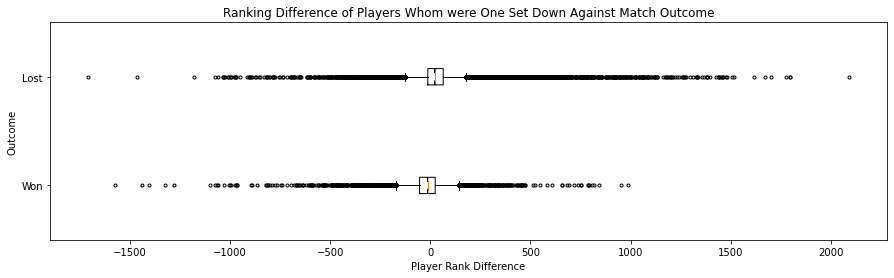

Outcome: Won
The lower quartile is: -54.0
The median is: -14.0
The upper quartile is: 24.0

Outcome: Lost
The lower quartile is: -13.0
The median is: 22.0
The upper quartile is: 64.0


In [7]:
won_rank_diff = df[(df['Has_Won']==1) & (df['Rank_Diff'].notna())]['Rank_Diff'].values.tolist()
lost_rank_diff = df[(df['Has_Won']==0) & (df['Rank_Diff'].notna())]['Rank_Diff'].values.tolist()
plt.figure(figsize=(15,4))
plt.boxplot([won_rank_diff, lost_rank_diff], vert=False, notch=True, flierprops={'marker': '.'})
plt.title('Ranking Difference of Players Whom were One Set Down Against Match Outcome')
plt.ylabel('Outcome')
plt.xlabel('Player Rank Difference')
plt.yticks([1,2], ['Won', 'Lost'])
plt.show()
print("Outcome: Won")
print(f'The lower quartile is: {np.percentile(won_rank_diff, 25)}')
print(f'The median is: {np.median(won_rank_diff)}')
print(f'The upper quartile is: {np.percentile(won_rank_diff, 75)}')
print()
print("Outcome: Lost")
print(f'The lower quartile is: {np.percentile(lost_rank_diff, 25)}')
print(f'The median is: {np.median(lost_rank_diff)}')
print(f'The upper quartile is: {np.percentile(lost_rank_diff, 75)}')

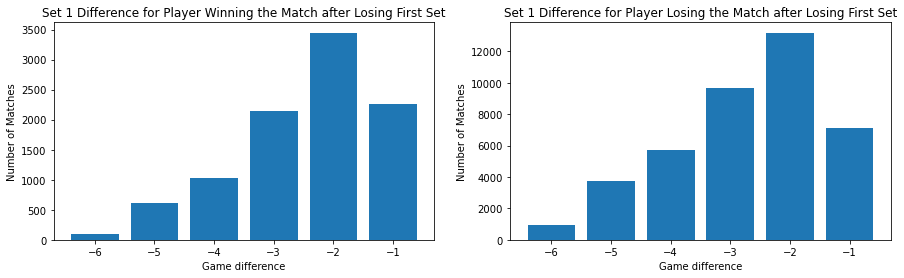

Outcome: Won
The lower quartile is: -3.0
The median is: -2.0
The upper quartile is: -2.0

Outcome: Lost
The lower quartile is: -4.0
The median is: -2.0
The upper quartile is: -2.0


In [8]:
won_set_diff = df[(df['Has_Won']==1) & (df['Set1_Diff'].notna())]['Set1_Diff'].values.tolist()
lost_set_diff = df[(df['Has_Won']==0) & (df['Set1_Diff'].notna())]['Set1_Diff'].values.tolist()

freqs, bins = np.histogram(won_set_diff, bins=6, range=(-6.5,-0.5))
won_set_dict = OrderedDict()
for i in range(len(bins)-1):
    won_set_dict[int(np.ceil(bins[i]))] = freqs[i]

freqs, bins = np.histogram(lost_set_diff, bins=6, range=(-6.5,-0.5))
lost_set_dict = OrderedDict()
for i in range(len(bins)-1):
    lost_set_dict[int(np.ceil(bins[i]))] = freqs[i]

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.title('Set 1 Difference for Player Winning the Match after Losing First Set')
plt.ylabel('Number of Matches')
plt.xlabel('Game difference')
plt.xticks(range(-6,0))
plt.bar(won_set_dict.keys(), won_set_dict.values())

plt.subplot(122)
plt.title('Set 1 Difference for Player Losing the Match after Losing First Set')
plt.ylabel('Number of Matches')
plt.xlabel('Game difference')
plt.xticks(range(-6,0))
plt.bar(lost_set_dict.keys(), lost_set_dict.values())

plt.show()

print("Outcome: Won")
print(f'The lower quartile is: {np.percentile(won_set_diff, 25)}')
print(f'The median is: {np.median(won_set_diff)}')
print(f'The upper quartile is: {np.percentile(won_set_diff, 75)}')
print()
print("Outcome: Lost")
print(f'The lower quartile is: {np.percentile(lost_set_diff, 25)}')
print(f'The median is: {np.median(lost_set_diff)}')
print(f'The upper quartile is: {np.percentile(lost_set_diff, 75)}')

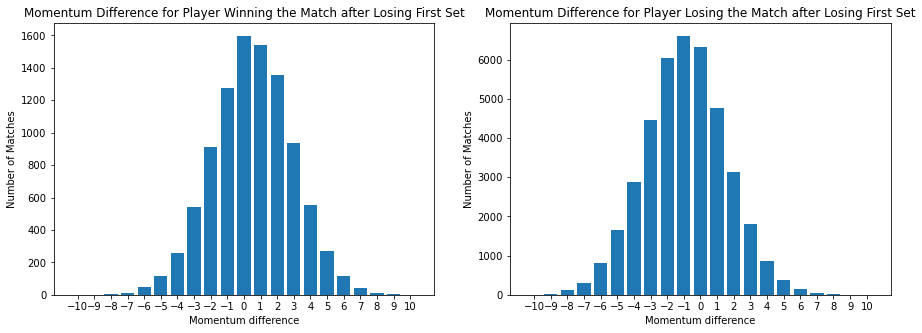

Outcome: Won
The lower quartile is: -1.0
The median is: 1.0
The upper quartile is: 2.0

Outcome: Lost
The lower quartile is: -3.0
The median is: -1.0
The upper quartile is: 1.0


In [9]:
won_momentum_diff = df[(df['Has_Won']==1) & (df['Momentum10_Diff'].notna())]['Momentum10_Diff'].values.tolist()
lost_momentum_diff = df[(df['Has_Won']==0) & (df['Momentum10_Diff'].notna())]['Momentum10_Diff'].values.tolist()

freqs, bins = np.histogram(won_momentum_diff, bins=21, range=(-10.5,10.5))
won_momentum_dict = OrderedDict()
for i in range(len(bins)-1):
    won_momentum_dict[int(np.ceil(bins[i]))] = freqs[i]
    
freqs, bins = np.histogram(lost_momentum_diff, bins=21, range=(-10.5,10.5))
lost_momentum_dict = OrderedDict()
for i in range(len(bins)-1):
    lost_momentum_dict[int(np.ceil(bins[i]))] = freqs[i]
    
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('Momentum Difference for Player Winning the Match after Losing First Set')
plt.ylabel('Number of Matches')
plt.xlabel('Momentum difference')
plt.xticks(range(-10,11))
plt.bar(won_momentum_dict.keys(), won_momentum_dict.values())

plt.subplot(122)
plt.title('Momentum Difference for Player Losing the Match after Losing First Set')
plt.ylabel('Number of Matches')
plt.xlabel('Momentum difference')
plt.xticks(range(-10,11))
plt.bar(lost_momentum_dict.keys(), lost_momentum_dict.values())

plt.show()

print("Outcome: Won")
print(f'The lower quartile is: {np.percentile(won_momentum_diff, 25)}')
print(f'The median is: {np.median(won_momentum_diff)}')
print(f'The upper quartile is: {np.percentile(won_momentum_diff, 75)}')
print()
print("Outcome: Lost")
print(f'The lower quartile is: {np.percentile(lost_momentum_diff, 25)}')
print(f'The median is: {np.median(lost_momentum_diff)}')
print(f'The upper quartile is: {np.percentile(lost_momentum_diff, 75)}')

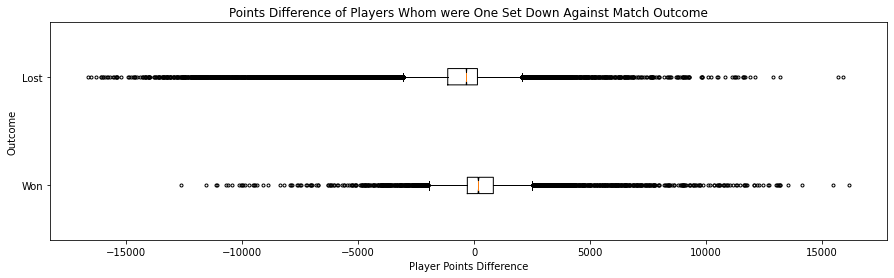

Outcome: Won
The lower quartile is: -292.0
The median is: 188.0
The upper quartile is: 828.25

Outcome: Lost
The lower quartile is: -1135.75
The median is: -328.0
The upper quartile is: 144.0


In [10]:
won_pts_diff = df[(df['Has_Won']==1) & (df['Pts_Diff'].notna())]['Pts_Diff'].values.tolist()
lost_pts_diff = df[(df['Has_Won']==0) & (df['Pts_Diff'].notna())]['Pts_Diff'].values.tolist()

plt.figure(figsize=(15,4))
plt.boxplot([won_pts_diff, lost_pts_diff], vert=False, notch=True, flierprops={'marker': '.'})
plt.title('Points Difference of Players Whom were One Set Down Against Match Outcome')
plt.ylabel('Outcome')
plt.xlabel('Player Points Difference')
plt.yticks([1,2], ['Won', 'Lost'])
plt.show()
print("Outcome: Won")
print(f'The lower quartile is: {np.percentile(won_pts_diff, 25)}')
print(f'The median is: {np.median(won_pts_diff)}')
print(f'The upper quartile is: {np.percentile(won_pts_diff, 75)}')
print()
print("Outcome: Lost")
print(f'The lower quartile is: {np.percentile(lost_pts_diff, 25)}')
print(f'The median is: {np.median(lost_pts_diff)}')
print(f'The upper quartile is: {np.percentile(lost_pts_diff, 75)}')


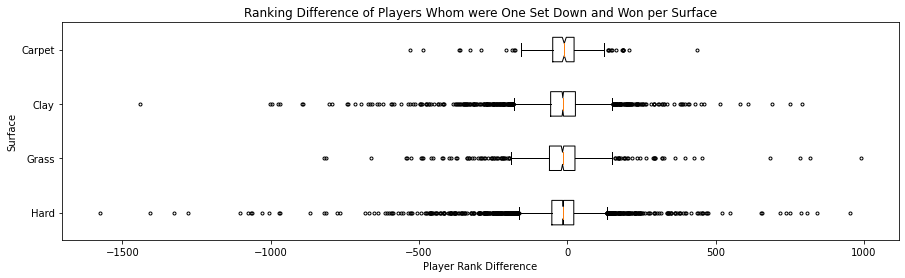

Surface: Clay
The lower quartile is: -52.0
The median is: -14.0
The upper quartile is: 22.0
IQR is: 74.0

Surface: Grass
The lower quartile is: -60.0
The median is: -16.0
The upper quartile is: 26.0
IQR is: 86.0

Surface: Hard
The lower quartile is: -56.0
The median is: -15.0
The upper quartile is: 27.5
IQR is: 83.5


In [11]:
# But does the surface type have any impact on the likelihood of winning after a set down
won_rank_diff_surfaces = []

surfaces = sorted(df['Surface'].unique().tolist(), reverse=True)

for surface in surfaces:
    data = df[(df['Has_Won']==1) & (df['Rank_Diff'].notna()) & (df['Surface']==surface)]['Rank_Diff'].values.tolist()
    won_rank_diff_surfaces.append(data)
plt.figure(figsize=(15,4))
plt.boxplot(won_rank_diff_surfaces, vert=False, notch=True, flierprops={'marker':'.'})
plt.title('Ranking Difference of Players Whom were One Set Down and Won per Surface')
plt.ylabel('Surface')
plt.xlabel('Player Rank Difference')
plt.yticks([i for i in range(1, len(surfaces)+1)], surfaces)
plt.show()

print("Surface: Clay")
print(f'The lower quartile is: {np.percentile(won_rank_diff_surfaces[0], 25)}')
print(f'The median is: {np.median(won_rank_diff_surfaces[0])}')
print(f'The upper quartile is: {np.percentile(won_rank_diff_surfaces[0], 75)}')
print(f'IQR is: {np.percentile(won_rank_diff_surfaces[0], 75) - np.percentile(won_rank_diff_surfaces[0], 25)}')
print()
print("Surface: Grass")
print(f'The lower quartile is: {np.percentile(won_rank_diff_surfaces[1], 25)}')
print(f'The median is: {np.median(won_rank_diff_surfaces[1])}')
print(f'The upper quartile is: {np.percentile(won_rank_diff_surfaces[1], 75)}')
print(f'IQR is: {np.percentile(won_rank_diff_surfaces[1], 75) - np.percentile(won_rank_diff_surfaces[1], 25)}')
print()
print("Surface: Hard")
print(f'The lower quartile is: {np.percentile(won_rank_diff_surfaces[2], 25)}')
print(f'The median is: {np.median(won_rank_diff_surfaces[2])}')
print(f'The upper quartile is: {np.percentile(won_rank_diff_surfaces[2], 75)}')
print(f'IQR is: {np.percentile(won_rank_diff_surfaces[2], 75) - np.percentile(won_rank_diff_surfaces[2], 25)}')

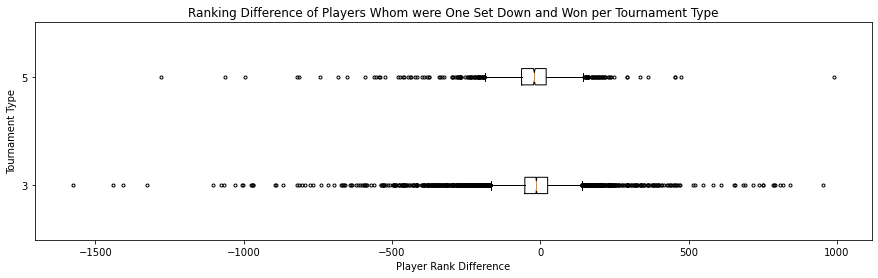

Tournament Type: ATP
The lower quartile is: -52.0
The median is: -13.0
The upper quartile is: 25.0
IQR is: 77.0

Tournament Type: Grandslam
The lower quartile is: -63.0
The median is: -20.0
The upper quartile is: 20.0
IQR is: 83.0



In [12]:
# Does it matter if grandslam vs non-grandslam

won_rank_diff_slam = []

tournament_types = sorted(df['Best of'].unique().tolist())

for tournament_type in tournament_types:
    data = df[(df['Has_Won']==1) & (df['Rank_Diff'].notna()) & (df['Best of']==tournament_type)]['Rank_Diff'].values.tolist()
    won_rank_diff_slam.append(data)
    
plt.figure(figsize=(15,4))
plt.boxplot(won_rank_diff_slam, vert=False, notch=True, flierprops={'marker':'.'})
plt.title('Ranking Difference of Players Whom were One Set Down and Won per Tournament Type')
plt.ylabel('Tournament Type')
plt.xlabel('Player Rank Difference')
plt.yticks([i for i in range(1, len(tournament_types)+1)], tournament_types)
plt.show()

print("Tournament Type: ATP")
print(f'The lower quartile is: {np.percentile(won_rank_diff_slam[0], 25)}')
print(f'The median is: {np.median(won_rank_diff_slam[0])}')
print(f'The upper quartile is: {np.percentile(won_rank_diff_slam[0], 75)}')
print(f'IQR is: {np.percentile(won_rank_diff_slam[0], 75) - np.percentile(won_rank_diff_slam[0], 25)}')
print()
print("Tournament Type: Grandslam")
print(f'The lower quartile is: {np.percentile(won_rank_diff_slam[1], 25)}')
print(f'The median is: {np.median(won_rank_diff_slam[1])}')
print(f'The upper quartile is: {np.percentile(won_rank_diff_slam[1], 75)}')
print(f'IQR is: {np.percentile(won_rank_diff_slam[1], 75) - np.percentile(won_rank_diff_slam[1], 25)}')
print()

## Feature Engineering

In [79]:
# Importing our dataset we've exported out, to make it easier in case of issues
df = pd.read_excel(OUTPUT_DATA_PATH + OUTPUT_DATASET_FILE)
df

,Date,Court,Surface,Round,Best of,P_Avg_Odds,O_Avg_Odds,Set1_Diff,Rank_Diff,Pts_Diff,Momentum10_Diff,Has_Won
0,2001-01-01,Outdoor,Hard,1st Round,3,NaN,NaN,-3,929.0,NaN,0,0
1,2001-01-01,Outdoor,Hard,1st Round,3,2.183333,1.503333,-3,35.0,NaN,0,0
2,2001-01-01,Outdoor,Hard,1st Round,3,NaN,NaN,-2,-5.0,NaN,0,0
3,2001-01-01,Outdoor,Hard,1st Round,3,3.550000,1.200000,-2,76.0,NaN,0,0
4,2001-01-01,Outdoor,Hard,1st Round,3,2.450000,1.383333,-2,63.0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
50008,2019-11-15,Indoor,Hard,Round Robin,3,1.845000,2.020000,-2,-3.0,2760.0,-1,0
50009,2019-11-15,Indoor,Hard,Round Robin,3,1.415000,3.005000,-1,-5.0,5585.0,-1,1
50010,2019-11-16,Indoor,Hard,Semifinals,3,1.315000,3.625000,-3,-3.0,2190.0,4,0
50011,2019-11-16,Indoor,Hard,Semifinals,3,2.050000,1.820000,-2,2.0,-2080.0,0,0


In [80]:
# Checking how many entries we have for the round type
# We might consider to remove this since it may cause overfitting
df.groupby(['Round', 'Has_Won']).count()

Date  Court  Surface  Best of  P_Avg_Odds  O_Avg_Odds  \
Round         Has_Won                                                           
1st Round     0        18569  18569    18569    18569       18056       18055   
              1         4475   4475     4475     4475        4352        4353   
2nd Round     0        11289  11289    11289    11289       11166       11166   
              1         2562   2562     2562     2562        2538        2538   
3rd Round     0         2857   2857     2857     2857        2831        2831   
              1          667    667      667      667         663         663   
4th Round     0          671    671      671      671         670         670   
              1          182    182      182      182         182         182   
Quarterfinals 0         3835   3835     3835     3835        3793        3793   
              1          915    915      915      915         907         907   
Round Robin   0          280    280      280      280         270         270   
              1           64     64       64       64          63          63   
Semifinals    0         1924   1924     1924     1924        1897        1897   
              1          495    495      495      495         487         487   
The Final     0          985    985      985      985         968         968   
              1          243    243      243      243         239         239   

                       Set1_Diff  Rank_Diff  Pts_Diff  Momentum10_Diff  
Round         Has_Won                                                   
1st Round     0            18569      18478     13492            18569  
              1             4475       4461      3308             4475  
2nd Round     0            11289      11276      8478            11289  
              1             2562       2561      1937             2562  
3rd Round     0             2857       2856      2123             2857  
              1              667        667       500              667  
4th Round     0              671        671       518              671  
              1              182        182       139              182  
Quarterfinals 0             3835       3833      2907             3835  
              1              915        914       677              915  
Round Robin   0              280        280       239              280  
              1               64         64        57               64  
Semifinals    0             1924       1923      1440             1924  
              1              495        495       385              495  
The Final     0              985        985       745              985  
              1              243        243       185              243

In [81]:
df.groupby(['Court', 'Has_Won']).count()

Date  Surface  Round  Best of  P_Avg_Odds  O_Avg_Odds  \
Court   Has_Won                                                           
Indoor  0         7188     7188   7188     7188        7080        7080   
        1         1704     1704   1704     1704        1675        1675   
Outdoor 0        33222    33222  33222    33222       32571       32570   
        1         7899     7899   7899     7899        7756        7757   

                 Set1_Diff  Rank_Diff  Pts_Diff  Momentum10_Diff  
Court   Has_Won                                                   
Indoor  0             7188       7171      5482             7188  
        1             1704       1704      1304             1704  
Outdoor 0            33222      33131     24460            33222  
        1             7899       7883      5884             7899

### Further Removing Unnecessary Features

In [82]:
drop_cols = ['Date', 'Court']

# We are dropping Round because some datapoints have really small sample size, and hence might cause overfitting with model
# Also helps to keep the data from being sparse and having too many dimensions

df.drop(drop_cols, axis=1, inplace=True)

### Ensuring we have the right datatypes

In [83]:
# Ensure that the datatype for our df is right before we start encoding it
# Taking note that the following datatypes will have dummy variables auto-encoded
# (object, category)

print(df.dtypes)
print()

category_cols = ['Surface', 'Best of', 'Round']
df[category_cols] = df[category_cols].astype('category')

print(df.dtypes)

Surface             object
Round               object
Best of              int64
P_Avg_Odds         float64
O_Avg_Odds         float64
Set1_Diff            int64
Rank_Diff          float64
Pts_Diff           float64
Momentum10_Diff      int64
Has_Won              int64
dtype: object

Surface            category
Round              category
Best of            category
P_Avg_Odds          float64
O_Avg_Odds          float64
Set1_Diff             int64
Rank_Diff           float64
Pts_Diff            float64
Momentum10_Diff       int64
Has_Won               int64
dtype: object


In [84]:
df_dummies = pd.get_dummies(df, columns=category_cols)
df_dummies

,P_Avg_Odds,O_Avg_Odds,Set1_Diff,Rank_Diff,Pts_Diff,Momentum10_Diff,Has_Won,Surface_Carpet,Surface_Clay,Surface_Grass,...,Best of_3,Best of_5,Round_1st Round,Round_2nd Round,Round_3rd Round,Round_4th Round,Round_Quarterfinals,Round_Round Robin,Round_Semifinals,Round_The Final
0,NaN,NaN,-3,929.0,NaN,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,2.183333,1.503333,-3,35.0,NaN,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
2,NaN,NaN,-2,-5.0,NaN,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,3.550000,1.200000,-2,76.0,NaN,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
4,2.450000,1.383333,-2,63.0,NaN,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50008,1.845000,2.020000,-2,-3.0,2760.0,-1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
50009,1.415000,3.005000,-1,-5.0,5585.0,-1,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
50010,1.315000,3.625000,-3,-3.0,2190.0,4,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
50011,2.050000,1.820000,-2,2.0,-2080.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [85]:
df_dummies.count()

P_Avg_Odds             49082
O_Avg_Odds             49082
Set1_Diff              50013
Rank_Diff              49889
Pts_Diff               37130
Momentum10_Diff        50013
Has_Won                50013
Surface_Carpet         50013
Surface_Clay           50013
Surface_Grass          50013
Surface_Hard           50013
Best of_3              50013
Best of_5              50013
Round_1st Round        50013
Round_2nd Round        50013
Round_3rd Round        50013
Round_4th Round        50013
Round_Quarterfinals    50013
Round_Round Robin      50013
Round_Semifinals       50013
Round_The Final        50013
dtype: int64

In [86]:
# We notice that there is significantly more entries with missing/lacking Pts_Diff compared to Rank_Diff
# Since the two attributes are highly correlated anyway, we will drop Pts_Diff

df_dummies.drop('Pts_Diff', axis=1, inplace=True)
df_dummies.dropna(inplace=True)

print(df_dummies.shape)
df_dummies.groupby('Has_Won').count()

(48967, 20)


,P_Avg_Odds,O_Avg_Odds,Set1_Diff,Rank_Diff,Momentum10_Diff,Surface_Carpet,Surface_Clay,Surface_Grass,Surface_Hard,Best of_3,Best of_5,Round_1st Round,Round_2nd Round,Round_3rd Round,Round_4th Round,Round_Quarterfinals,Round_Round Robin,Round_Semifinals,Round_The Final
Has_Won,,,,,,,,,,,,,,,,,,,
0,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551
1,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416


## Model Selection

In [87]:
# Library imports

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline

In [88]:
# Setting our independent variables separate from our label array
df_X = df_dummies[[c for c in df_dummies if c not in ['Has_Won']]]
df_y = df_dummies['Has_Won']

# Transforming our Pandas DataFrame into numpy array
df_X = df_X.to_numpy()

# Doing the train/test split
# N.B. X here is NumPy array, while y is Pandas Series
# this means that X has a range index from 0 to N, while y has the original index from df_dummies, which we'll use later
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.25)

In [89]:
def betting_loss(y_true, y_pred, X=df_dummies):
    '''
    Calculates the loss based on the prediction and actual outcome
    INPUT: array for the actual outcome (y_true), array for the predicted outcome (y_pred)
    OUTPUT: scalar value indicating the INVERTED profit or loss.  This is inverted for the purposes of it being a minimisation
    function.  Therefore, a negative value here will indicate a profit and a positive value will indicate a loss
    '''

    # Converting y_pred from Pandas series to DataFrame, setting its index to equal y_true, and switching back to Series
    y_pred = pd.DataFrame(data=y_pred)
    y_pred.set_index(y_true.index, inplace=True)
    y_pred = pd.Series(data=y_pred[0], index=y_pred.index)
    
    # Obtaining the (non-iloc) indices in y_pred for the 3 categories: correct_win, correct_lose, incorrect_guess
    revenue_win_idx = list(y_pred[((y_true == y_pred) & (y_true == 1))].index)
    revenue_lose_idx = list(y_pred[((y_true == y_pred) & (y_true == 0))].index)
    loss_idx = list(y_pred[y_true != y_pred].index)
    
    # Assuming that we place a $1 bet for each match
    #revenue_win = X[revenue_win_idx, np.where(df_dummies.columns.to_numpy() == 'P_Avg_Odds')[0][0]].sum()
    revenue_win = X.loc[revenue_win_idx, 'P_Avg_Odds'].sum(axis=0)
    # We're setting this to just the length, because we don't know the actual odds of them continuing to win
    # since this should in theory be less than their odds before the match, hence being conservative with our estimate
    revenue_lose = len(revenue_lose_idx)
    loss = - revenue_win - revenue_lose + len(y_pred)
    
    print(f'Total number of matches: {y_pred.shape[0]}')
    #print(f'Total number of correct win: {len(revenue_win_idx)}')
    #print(f'Total number of correct loss: {len(revenue_lose_idx)}')
    #print(f'Total number of incorrect predictions: {len(loss_idx)}')
    #print(f'Revenue from correct win: {revenue_win}')
    print(f'Total Loss incurred: {loss}')
    
    return loss


# creating the scorer function here, to be used by GridSearchCV
betting_scorer = make_scorer(betting_loss, greater_is_better=False)

In [128]:
def get_best_parameters(classifier_list, X_train, X_test, y_train, y_test):
    for classifier in classifier_list:
        print(f'Beginning GridSearchCV for {classifier}')
        print()
        classifier.fit(X_train, y_train)
        y_pred = pd.Series(classifier.predict(X_test))
        betting_loss(y_test, y_pred)
        
        # Need to convert it into DataFrame and back to series in order to transfer our index for crosstab
        y_pred = pd.DataFrame(data=y_pred)
        y_pred.set_index(y_test.index, inplace=True)
        y_pred = pd.Series(data=y_pred[0], index=y_pred.index, name='Predicted')
        
        print(f'Best parameters found {classifier.best_estimator_}')
        print(classification_report(y_test, y_pred))
        print(pd.crosstab(y_test, y_pred))
        print()

In [90]:
# Preprocessing functions
scaler = MinMaxScaler()
pca = PCA(n_components=0.9, svd_solver='full') #to get explained variance >0.9 https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

# Classification functions
logreg = LogisticRegression(class_weight='balanced', multi_class='ovr', max_iter=1000)
svm = SVC(class_weight='balanced', max_iter=2000)
knn = KNeighborsClassifier()

### Dataset without normalisation nor PCA applied

In [131]:
# The Setup

# Parameters for each classification function
logreg_params = {
    'solver': ['liblinear', 'saga']
}
svm_params = {
    'kernel': ['poly', 'rbf', 'sigmoid']
}
knn_params = {}

# GridSearchCV for each classification function
logreg_clf = GridSearchCV(logreg, logreg_params, scoring=betting_scorer, cv=5)
svm_clf = GridSearchCV(svm, svm_params, scoring=betting_scorer, cv=5)
knn_clf = GridSearchCV(knn, knn_params, scoring=betting_scorer, cv=5)

# Running the GridSearch with CrossValidation
get_best_parameters([logreg_clf, svm_clf, knn_clf], X_train, X_test, y_train, y_test)

### Dataset with scaling applied

In [134]:
# The Setup

# Pipelines for each classification function
logreg_pipe = Pipeline([('scale', scaler),
                       ('logistic_regression', logreg)])
svm_pipe = Pipeline([('scale', scaler),
                    ('svm', svm)])
knn_pipe = Pipeline([('scale', scaler),
                    ('knn', knn)])

# Parameters for the pipeline for each classification function
logreg_params = {
    'logistic_regression__solver': ['liblinear', 'saga']
}
svm_params = {
    'svm__kernel': ['poly', 'rbf', 'sigmoid']
}
knn_params = {}

# GridsearchCV for each classification function
logreg_clf = GridSearchCV(logreg_pipe, logreg_params, scoring=betting_scorer, cv=5)
svm_clf = GridSearchCV(svm_pipe, svm_params, scoring=betting_scorer, cv=5)
knn_clf = GridSearchCV(knn_pipe, knn_params, scoring=betting_scorer, cv=5)

# Running the GridSearch with CrossValidation
get_best_parameters([logreg_clf, svm_clf, knn_clf], X_train, X_test, y_train, y_test)

Beginning GridSearchCV for GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('logistic_regression',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           multi_class='ovr'))]),
             param_grid={'logistic_regression__solver': ['liblinear', 'saga']},
             scoring=make_scorer(betting_loss, greater_is_better=False))

Total number of matches: 7345
Total Loss incurred: 1995.9539833333329
Total number of matches: 7345
Total Loss incurred: 1934.007466666666
Total number of matches: 7345
Total Loss incurred: 1959.8703000000005
Total number of matches: 7345
Total Loss incurred: 1928.4873333333335
Total number of matches: 7345
Total Loss incurred: 1971.6674000000003
Total number of matches: 7345
Total Loss incurred: 1993.9539833333329
Total number

c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 3368.4391833333334


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4555.074866666667


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4258.2411833333335


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4595.007833333333


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4419.119466666667


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4575.2359


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4579.20945


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4521.530183333333


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4595.007833333333


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4540.193083333334


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4505.42285


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 1988.2739333333338


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 3836.9071


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4594.007833333333


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4190.810166666667


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 12242
Total Loss incurred: 6356.1124500000005
Best parameters found Pipeline(steps=[('scale', MinMaxScaler()),
                ('svm',
                 SVC(class_weight='balanced', kernel='sigmoid',
                     max_iter=2000))])
              precision    recall  f1-score   support

           0       0.90      0.18      0.30      9859
           1       0.21      0.91      0.34      2383

    accuracy                           0.32     12242
   macro avg       0.55      0.55      0.32     12242
weighted avg       0.76      0.32      0.31     12242

Predicted     0     1
Has_Won              
0          1773  8086
1           203  2180

Beginning GridSearchCV for GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={},
             scoring=make_scorer(betting_loss, greater_is_better=False))

Total number of matches: 7345
Tot

#### Dataset with scaling and PCA applied

In [135]:
# Pipelines for each classification function
logreg_pipe = Pipeline([('scale', scaler),
                       ('pca', pca),
                       ('logistic_regression', logreg)])
svm_pipe = Pipeline([('scale', scaler),
                    ('pca', pca),
                    ('svm', svm)])
knn_pipe = Pipeline([('scale', scaler),
                    ('pca', pca),
                    ('knn', knn)])

# Parameters for the pipeline for each classification function
logreg_params = {
    'logistic_regression__solver': ['liblinear', 'saga']
}
svm_params = {
    'svm__kernel': ['poly', 'rbf', 'sigmoid']
}
knn_params = {}

# GridsearchCV for each classification function
logreg_clf = GridSearchCV(logreg_pipe, logreg_params, scoring=betting_scorer, cv=5)
svm_clf = GridSearchCV(svm_pipe, svm_params, scoring=betting_scorer, cv=5)
knn_clf = GridSearchCV(knn_pipe, knn_params, scoring=betting_scorer, cv=5)

# Running GridSearch with CrossValidation
get_best_parameters([logreg_clf, svm_clf, knn_clf], X_train, X_test, y_train, y_test)

Beginning GridSearchCV for GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('pca',
                                        PCA(n_components=0.9,
                                            svd_solver='full')),
                                       ('logistic_regression',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           multi_class='ovr'))]),
             param_grid={'logistic_regression__solver': ['liblinear', 'saga']},
             scoring=make_scorer(betting_loss, greater_is_better=False))

Total number of matches: 7345
Total Loss incurred: 2786.4342166666665
Total number of matches: 7345
Total Loss incurred: 2752.4731666666667
Total number of matches: 7345
Total Loss incurred: 2780.114083333334
Total number of matches: 7345
Total Loss incurre

c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4570.645066666666


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4475.273866666666


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4392.457183333334


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4595.007833333333


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4401.0996


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4575.2359


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4579.20945


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4521.530183333333


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4595.007833333333


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4540.193083333334


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4575.2359


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4579.20945


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4521.530183333333


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4595.007833333333


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 7345
Total Loss incurred: 4540.193083333334


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Total number of matches: 12242
Total Loss incurred: 7460.628383333334
Best parameters found Pipeline(steps=[('scale', MinMaxScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('svm',
                 SVC(class_weight='balanced', kernel='poly', max_iter=2000))])
              precision    recall  f1-score   support

           0       0.82      0.01      0.02      9859
           1       0.19      0.99      0.33      2383

    accuracy                           0.20     12242
   macro avg       0.51      0.50      0.17     12242
weighted avg       0.70      0.20      0.08     12242

Predicted    0     1
Has_Won             
0          100  9759
1           22  2361

Beginning GridSearchCV for GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('pca',
                                        PCA(n_components=0.9,
                                            svd_solver='full')